In [1]:
import scvelo as scv
import scanpy as sc
scv.logging.print_version()
import numpy as np
import pandas as pd
import os

Running scvelo 0.2.4 (python 3.8.5) on 2022-08-30 20:49.


In [36]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
#scv.set_figure_params('scvelo')  # for beautified visualization

In [3]:
adata = sc.read('../../Data/adata_Neoblast.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 14601 × 3000
    obs: 'TimePoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'scrublet_score', 'louvain', 'leiden', 'DBSCAN', 'Annotation', 'CellType', 'Neoblat', 'Neoblast'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'n_cells_by_counts-2', 'mean_counts-2', 'log1p_mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'log1p_total_counts-2', 'n_cells_by_counts-3', 'mean_counts-3', 'log1p_mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3', 'log1p_total_counts-3', 'n_cells_by_counts-4', 'mean_counts-4', 'log1p_

In [5]:
loom_dir = '../../../Velocity/loom_adata'

In [6]:
file_list = [x for x in os.listdir(loom_dir) if x.endswith('h5ad')]

In [7]:
file_list

['cut0h.h5ad',
 'cut12h.h5ad',
 'cut24h.h5ad',
 'cut2d.h5ad',
 'cut3d.h5ad',
 'cut5d.h5ad',
 'cut6h.h5ad',
 'cut7d.h5ad']

In [8]:
adata_loom = sc.read(os.path.join(loom_dir, file_list[0]))
for it in file_list[1:]:
    print(it)
    temp_adata = sc.read(os.path.join(loom_dir, it))
    adata_loom = adata_loom.concatenate(temp_adata)

cut12h.h5ad
cut24h.h5ad
cut2d.h5ad
cut3d.h5ad
cut5d.h5ad
cut6h.h5ad
cut7d.h5ad


In [9]:
adata_loom.obs_names = [x[:20] for x in adata_loom.obs_names]

In [10]:
np.intersect1d(adata.obs_names, adata_loom.obs_names).shape

(14518,)

In [11]:
adata_Velo = adata_loom[np.intersect1d(adata.obs_names, adata_loom.obs_names),]

In [12]:
adata_Velo

View of AnnData object with n_obs × n_vars = 14518 × 30917
    obs: 'Clusters', '_X', '_Y', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [13]:
UMAP_df = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names)

In [14]:
adata_Velo.obsm['X_umap'] = UMAP_df.loc[adata_Velo.obs_names,].values

In [15]:
adata_Velo.obs['DBSCAN'] = adata.obs.loc[adata_Velo.obs_names, 'DBSCAN']

In [16]:
scv.pp.filter_genes(adata_Velo, min_shared_counts=20)
scv.pp.normalize_per_cell(adata_Velo)
scv.pp.filter_genes_dispersion(adata_Velo, n_top_genes=2000)
scv.pp.log1p(adata_Velo)

Filtered out 21144 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.


In [17]:
adata_Velo

AnnData object with n_obs × n_vars = 14518 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'DBSCAN', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [18]:
scv.pp.filter_and_normalize(adata_Velo, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata_Velo, n_pcs=30, n_neighbors=30)

Filtered out 51 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:24) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [19]:
scv.tl.velocity(adata_Velo)

computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [20]:
scv.tl.velocity_graph(adata_Velo)

computing velocity graph (using 1/40 cores)



    finished (0:01:57) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [21]:
sc.set_figure_params(dpi=200, dpi_save=300)

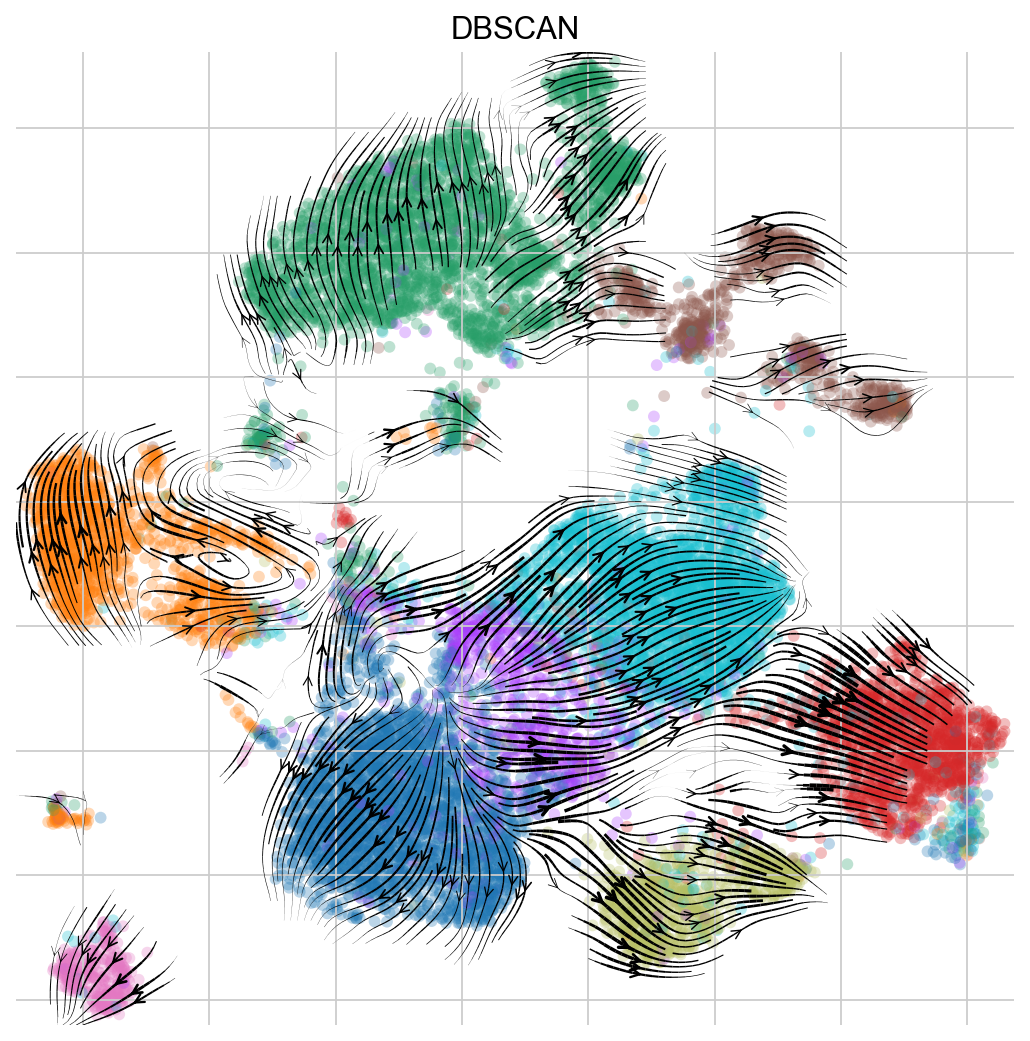

In [37]:
sc.set_figure_params(figsize=[8, 8])
scv.pl.velocity_embedding_stream(adata_Velo, basis='umap', color='DBSCAN', density=5, arrow_style='->',
                                 legend_loc=False, max_length=10)

<AxesSubplot:title={'center':'Louvain (resolution=1.5)'}, xlabel='UMAP1', ylabel='UMAP2'>

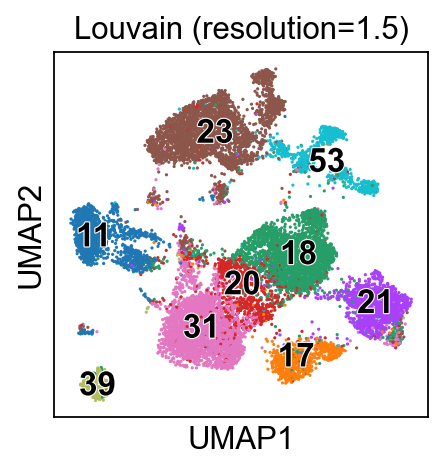

In [26]:
sc.set_figure_params(figsize=[3, 3])
sc.pl.umap(adata_Velo, color='DBSCAN', show=False,legend_fontsize=15, legend_fontoutline=1,
           add_outline=False, legend_loc='on data', title='Louvain (resolution=1.5)')#, save='Louvain_1p5.png')


<AxesSubplot:title={'center':'Louvain (resolution=1.5)'}, xlabel='UMAP1', ylabel='UMAP2'>

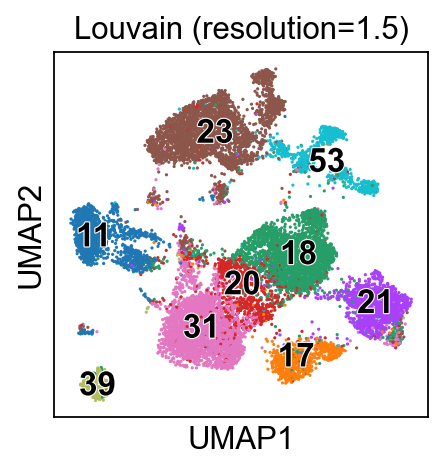

In [26]:
sc.set_figure_params(figsize=[3, 3])
sc.pl.umap(adata_Velo, color='DBSCAN', show=False,legend_fontsize=15, legend_fontoutline=1,
           add_outline=False, legend_loc='on data', title='Louvain (resolution=1.5)')#, save='Louvain_1p5.png')


In [27]:
color_dict = {'23':'#279e68', '53':'#8c564b', '11':'#ff7f0e', '39':'#e377c2', 
              '31':'#1f77b4', '20':'#aa40fc', '18':'#17becf', '17':'#b5bd61', '21':'#d62728'}

In [31]:
adata_Velo.uns['DBSCAN_colors'] = [color_dict[x] for x in adata_Velo.obs['DBSCAN'].cat.categories]

<AxesSubplot:title={'center':'Louvain (resolution=1.5)'}, xlabel='UMAP1', ylabel='UMAP2'>

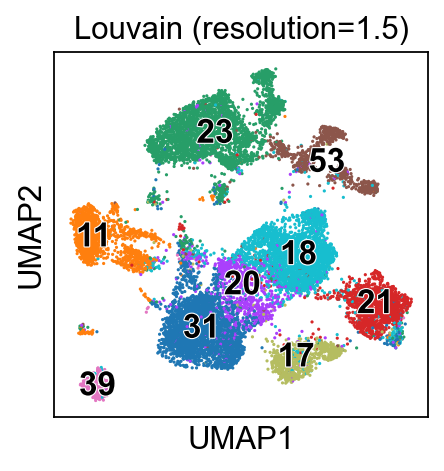

In [32]:
sc.set_figure_params(figsize=[3, 3])
sc.pl.umap(adata_Velo, color='DBSCAN', show=False,legend_fontsize=15, legend_fontoutline=1,
           add_outline=False, legend_loc='on data', title='Louvain (resolution=1.5)')#, save='Louvain_1p5.png')

In [46]:
import matplotlib.pyplot as plt

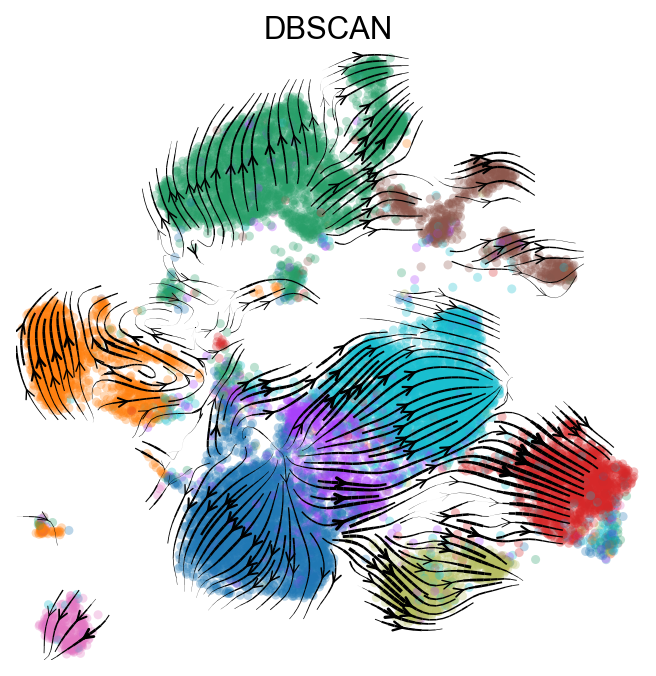

In [55]:
sc.set_figure_params(figsize=[5,5])
fig, ax = plt.subplots(figsize=[5,5])
scv.pl.velocity_embedding_stream(adata_Velo, basis='umap', color='DBSCAN', density=3, arrow_style='->',
                                 legend_loc=False, max_length=10, ax=ax, show=False)
ax.grid(False)
plt.savefig('scVelo_Neoblast.pdf',dpi=500, bbox_inches='tight')